In [ ]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset

fatal: destination path 'small_dog_cat_dataset' already exists and is not an empty directory.


In [ ]:
!pip install timm

In [ ]:
import math
import torch
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
'''
  Function for computing the accuracy of the predictions over the entire data loader
'''
def get_accuracy(model, data_loader, device):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [ ]:
'''
  Function for plotting trainning and validation losses
'''
def plot_losses(train_acc,valid_acc,train_loss,valid_loss):
  plt.style.use('seaborn')

  train_acc = np.array(train_acc)
  valid_acc = np.array(valid_acc)

  fig, (ax1,ax2) = plt.subplots(1,2)
  ax1.plot(train_acc,color='blue',label='train_acc')
  ax1.plot(valid_acc,color='red',label='valid_acc')
  ax1.set(title='Acc over epochs',
          xlabel='epochs',
          ylabel='acc')
  ax1.legend()

  ax2.plot(train_loss,color='blue',label='train_loss')
  ax2.plot(valid_loss,color='red',label='valid_loss')
  ax2.set(title='Loss over epochs',
          xlabel='epochs',
          ylabel='loss')
  ax2.legend()
  fig.show()
  plt.style.use('default')

In [ ]:
'''
  fuction for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0.0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)

    loss = criterion(outputs, labels)
    running_loss += loss.item()

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [ ]:
'''
  fuction for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0.

  with torch.no_grad():
    for images, labels in valid_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss

In [ ]:
'''
  function defining the training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  best_loss = 1e10
  train_losses = []
  valid_losses = []
  list_train_acc = []
  list_valid_acc = []

  for epoch in range(0, epochs):
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

    model, valid_loss = validate(valid_loader, model, criterion, device)

    if epoch % print_every == (print_every - 1):
      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      print('Epoch: {}/{}.. '.format(epoch+1, epochs),
            'Training Loss: {:.3f}.. '.format(train_loss),
            'Training Acc: {:.3f}.. '.format(train_acc),
            'Valid Loss: {:.3f}.. '.format(valid_loss),
            'Valid Acc: {:.3f}'.format(valid_acc))
      list_train_acc.append(train_acc)
      list_valid_acc.append(valid_acc)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
  plot_losses(list_train_acc,list_valid_acc,train_losses,valid_losses)
  return model, optimizer, (train_losses, valid_losses)

In [ ]:
import os
import cv2
from torch.utils.data import DataLoader, Dataset
import albumentations

class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_labels = {'dogs':1,'cats':0}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir,sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir,image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)
    self.transform = transform

  def __len__(self):
    return len(self.list_images_path)

  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    label = np.array(self.one_hot_labels[self.list_labels[idx]])

    if self.transform:
      res = self.transform(image=image)
      image = res['image'].astype(np.float32)
    else:
      image = image.astype(np.float32)

    image = image.transpose(2,0,1)
    sample = (image,label)
    return sample


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def get_tranforms(image_size=(224,224)):
  tranform_train = albumentations.Compose([
      albumentations.HorizontalFlip(p=0.5),
      albumentations.ImageCompression(quality_lower=99, quality_upper=100),
      albumentations.ShiftScaleRotate(shift_limit=0.2,scale_limit=0.2,rotate_limit=10,border_mode=0,p=0.7),
      # albumentations.Resize(image_size,image_size),
      # albumentations.Cutout(max_h_size=int(image_size[0]*0.4),max_w_size=int(image_size[1]*0.4),num_holes=1,p=0.5),
      albumentations.Normalize()
  ])
  tranform_val = albumentations.Compose([
      albumentations.HorizontalFlip(p=0.5),
      albumentations.ImageCompression(quality_lower=99, quality_upper=100),
      albumentations.ShiftScaleRotate(shift_limit=0.2,scale_limit=0.2,rotate_limit=10,border_mode=0,p=0.7),
      # albumentations.Resize(image_size,image_size),
      # albumentations.Cutout(max_h_size=int(image_size[0]*0.4),max_w_size=int(image_size[1]*0.4),num_holes=1,p=0.5),
      albumentations.Normalize()
  ])
  return tranform_train, tranform_val


In [ ]:
tranforms_train,transforms_val = get_tranforms()

In [ ]:
tranforms_train_data = DogCatDataset(root_dir='./small_dog_cat_dataset/train',transform=tranforms_train)
tranforms_test_data = DogCatDataset(root_dir='./small_dog_cat_dataset/test',transform=transforms_val)

In [ ]:
train_data_loader = DataLoader(tranforms_train_data,batch_size=32,shuffle=True)
test_data_loader = DataLoader(tranforms_test_data,batch_size=32,shuffle=True)

Ensembel model

In [ ]:
class EnsembelModel(nn.Module):
  def __init__ (self,num_classes=2, pretrained= False):
    super(EnsembelModel,self).__init__()
    self.model_b0 = timm.create_model('efficientnet_b0',pretrained=pretrained,drop_path_rate=0.2)
    self.model_b2 = timm.create_model('efficientnet_b2',pretrained=pretrained,drop_path_rate=0.2)

    self.dense1 = nn.Linear(1280,512)
    self.dense2 = nn.Linear(1408,512)

    self.classifier = nn.Linear(512,num_classes)

  def mixup_one_target(self,x1,x2,alpha=0.1,is_bias=False):
    ''' Returns mixed inputs, mixed targets, and lamda '''
    if alpha > 0:
      lam = np.random.beta(alpha, alpha)
    else:
      lam = 1
    if is_bias:
      lam = max(lam,1-lam)

    mixed_x = lam * x1 + (1 - lam) * x2
    return mixed_x
  def forward(self,x):
    x1 = self.model_b0.forward_features(x)
    x2 = self.model_b2.forward_features(x)

    x1 = F.avg_pool2d(x1,7)
    x2 = F.avg_pool2d(x2,7)

    x1 = x1.view(x1.size(0),-1)
    x2 = x2.view(x2.size(0),-1)

    x1 = self.dense1(x1)
    x2 = self.dense2(x2)

    x = self.mixup_one_target(x2,x1,alpha=0.5,is_bias=True)
    x = self.classifier(x)
    return x



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = EnsembelModel(num_classes=2,pretrained=True)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

Epoch: 1/5..  Training Loss: 0.006..  Training Acc: 99.100..  Valid Loss: 0.001..  Valid Acc: 98.500
Epoch: 2/5..  Training Loss: 0.001..  Training Acc: 99.750..  Valid Loss: 0.001..  Valid Acc: 97.833
Epoch: 3/5..  Training Loss: 0.001..  Training Acc: 99.850..  Valid Loss: 0.001..  Valid Acc: 98.667
Epoch: 4/5..  Training Loss: 0.001..  Training Acc: 99.850..  Valid Loss: 0.001..  Valid Acc: 98.167
Epoch: 5/5..  Training Loss: 0.001..  Training Acc: 100.000..  Valid Loss: 0.001..  Valid Acc: 98.667


<ipython-input-5-23f67acd9294>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


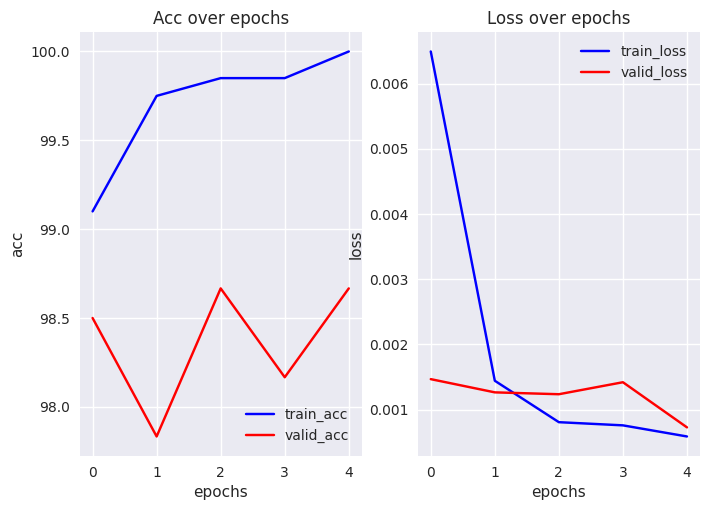

In [ ]:
loss_fuction = nn.CrossEntropyLoss()
model,optimizer,_ = training_loop(model,loss_fuction,optimizer,train_data_loader,test_data_loader,epochs=5,device=device)